In [31]:
model_size = "70m"  # or 2.8b

In [32]:
import matplotlib.pyplot as plt
import torch
import torch.nn
import torch.optim
from transformers import GPTNeoXForCausalLM, AutoTokenizer

In [33]:
tokenizer = AutoTokenizer.from_pretrained(
  f"EleutherAI/pythia-{model_size}-deduped",
  revision="step3000",
  cache_dir=f"./pythia-{model_size}-deduped/step3000",
)

In [34]:
model = GPTNeoXForCausalLM.from_pretrained(
  f"EleutherAI/pythia-{model_size}-deduped",
  revision="step3000",
  cache_dir=f"./pythia-{model_size}-deduped/step3000",
)

In [35]:
train_data = tokenizer("Training example #1 is continuing just this text. That's all.", return_tensors="pt")

In [36]:
# This actually samples from the model and continues the inputs sequence.
model.generate(**train_data, max_length=30)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


tensor([[47416,  1650,  1852,    18,   310, 11440,   816,   436,  2505,    15,
          2064,   434,   512,    15,   187,   187,    34,    27,   187,   187,
            42,  1158,   368,  1472,   987,    15,   309,  1158,   368,  1472]])

In [37]:
# This is one parallel forward pass through the model, useful for training / perplexity on a sentence.
# Output logits have the shape (batch, num_tokens, vocab_size)
model(**train_data).logits.shape

torch.Size([1, 14, 50304])

Vocab is ~50k. Tradeoff between memory consumption (long seq len) and more model parameters.

Last layer parameters in this case: $50304 \times 512 = 25M$

In [38]:
dict(model.named_modules())['gpt_neox.embed_in']

Embedding(50304, 512)

(Or is it shared with the emb space?) Comparison of `gpt_neox.embed_in` and `embed_out`

In [39]:
dict(model.named_modules())['embed_out']

Linear(in_features=512, out_features=50304, bias=False)

## First and last layer inspection

In [40]:
emb_out_layer = dict(model.named_modules())['embed_out']
emb_in_layer = dict(model.named_modules())['gpt_neox.embed_in']

list(emb_out_layer.parameters())[0], list(emb_in_layer.parameters())[0]

(Parameter containing:
 tensor([[-0.0324,  0.0372, -0.0339,  ...,  0.0141, -0.0041,  0.0731],
         [-0.0323,  0.0438, -0.0388,  ..., -0.0005,  0.0452,  0.0865],
         [ 0.0770, -0.0487,  0.0957,  ...,  0.0418, -0.0245,  0.0255],
         ...,
         [ 0.0094,  0.0218, -0.0342,  ...,  0.0123,  0.0355,  0.0566],
         [-0.0061,  0.0197, -0.0467,  ...,  0.0004, -0.0008,  0.0076],
         [ 0.0226, -0.0023, -0.0380,  ...,  0.0126,  0.0422,  0.0599]],
        requires_grad=True),
 Parameter containing:
 tensor([[ 0.0308, -0.0087,  0.0353,  ...,  0.0028,  0.0612, -0.0313],
         [-0.0188,  0.0053, -0.0140,  ...,  0.0042, -0.0359, -0.0329],
         [-0.0215, -0.0540, -0.0469,  ..., -0.0137,  0.0544, -0.0139],
         ...,
         [-0.0400,  0.0041, -0.0577,  ..., -0.0170,  0.0236, -0.0073],
         [-0.0121, -0.0004,  0.0441,  ..., -0.0316, -0.0187,  0.0260],
         [ 0.0440,  0.0214,  0.0234,  ..., -0.0043, -0.0058, -0.0082]],
        requires_grad=True))

activation_i (512) @ large_weight_matrix (512x50k) ==> logits

May --> month
May --> ask for permission
"The word to greet is ____" --> logits("hi") --> high value; logits("hello") --> high value

In [41]:
vocab_emb_mat = list(emb_out_layer.parameters())[0]

In [42]:
def get_similar_words(word: str) -> list[str]:
    hello_emb = vocab_emb_mat[tokenizer(word)['input_ids'][0]]
    sim_scores = vocab_emb_mat @ hello_emb
    top_similar = torch.argsort(sim_scores, descending=True)[:20]
    return [tokenizer.decode([s]) for s in top_similar]

In [43]:
print(*get_similar_words("aa"), sep=" | ")

aa | aaa | aaaa | ais | aan | ae | a | aea | uu | af | aaaaaaaa | aq | ua | avat | ana | ea | aha | afa | eed | ira


In [44]:
print(*get_similar_words("Test"), sep=" | ")

Test | TestCase | Tests | Testing | test |  Test |  Tests | Mock | tests | Unit | Ignore | testing | Suite | Sample | Trial | TEST | Rule | ittest | Assert | Override


In [45]:
print(*get_similar_words("Hello"), sep=" | ")

Hello | Hi | hello | Welcome | Dear | Hey | Wow |  Hello | Excuse | Nice | Looks | Yesterday | Bye | Sorry | Alright | Excellent | Been | ====== | Yeah | noreply


In [46]:
print(*get_similar_words("May"), sep=" | ")

May | April | June | October | February | March | November | July | December | September | August | January | Feb | Apr | Aug | Sept | Nov | Oct | Jun | Jan


## Run fine-tuning

In [58]:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

In [84]:
result = tokenizer([
        "hi",
        "how are you",
        "this is"
    ],
    add_special_tokens=True,
    return_tensors="pt",
    padding='longest',
    return_attention_mask=True,)

In [85]:
result

{'input_ids': tensor([[5801,    0,    0],
        [5430,  403,  368],
        [2520,  310,    0]]), 'attention_mask': tensor([[1, 0, 0],
        [1, 1, 1],
        [1, 1, 0]])}

In [80]:
input_tokens = result["input_ids"]
batch_size = input_tokens.shape[0]
input_tokens = torch.concat(
    [
        torch.tensor(tokenizer.bos_token_id).expand((batch_size, 1)),
        input_tokens,
    ],
    axis=-1)
target_tokens = torch.concat([
        input_tokens[:, 1:],
        torch.tensor(tokenizer.eos_token_id).expand((batch_size, 1)),
    ],
    axis=-1)
result["input_ids"] = input_tokens
result["target_ids"] = target_tokens

In [81]:
result

{'input_ids': tensor([[   0,    0, 5801,    0,    0],
        [   0,    0, 5430,  403,  368],
        [   0,    0, 2520,  310,    0]]), 'attention_mask': tensor([[1, 0, 0],
        [1, 1, 1],
        [1, 1, 0]]), 'target_ids': tensor([[   0, 5801,    0,    0,    0],
        [   0, 5430,  403,  368,    0],
        [   0, 2520,  310,    0,    0]])}

In [47]:
train_data = tokenizer("Training example #1 is continuing just this text. That's all.", return_tensors="pt")

In [48]:
# Shift input by one so we train on "next word prediction".
# Add the EOS token so we have a target for the last word.
target = torch.concat([
    train_data['input_ids'][:,1:], 
    torch.tensor([[tokenizer.eos_token_id]])
    ], axis=-1)
target

tensor([[ 1650,  1852,    18,   310, 11440,   816,   436,  2505,    15,  2064,
           434,   512,    15,     0]])

End of text in the output?

In [16]:
tokenizer.decode(target[0])

" example #1 is continuing just this text. That's all.<|endoftext|>"

In [17]:
num_steps = 100

losses = []

model.train()
opt = torch.optim.Adam(model.parameters(), lr=5e-5)
ce_loss_fn = torch.nn.CrossEntropyLoss()

for step in range(num_steps):
    opt.zero_grad()
    logits = model(**train_data).logits.permute([0, 2, 1])
    loss = ce_loss_fn(logits, target)
    losses.append(loss.item())
    loss.backward()
    opt.step()
    

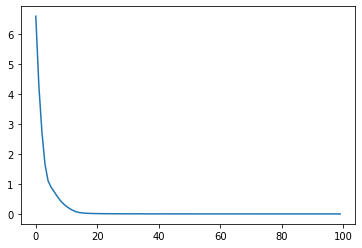

In [18]:
plt.plot(losses)

In [19]:
model.eval();

In [20]:
model_pre_trained = GPTNeoXForCausalLM.from_pretrained(
  f"EleutherAI/pythia-{model_size}-deduped",
  revision="step3000",
  cache_dir=f"./pythia-{model_size}-deduped/step3000",
)

In [21]:
def generate(model, text: str) -> str:
    tokens = model.generate(
        **tokenizer(text, return_tensors="pt"),
        pad_token_id=tokenizer.eos_token_id, max_length=30)
    return tokenizer.decode(tokens[0])

def generate_sxs(text: str) -> dict[str, str]:
    return {
        'fine-tuned': generate(model, text),
        'pre-trained': generate(model_pre_trained, text),
    }

In [22]:
generate_sxs("Training")

{'fine-tuned': "Training example #1 is continuing just this text. That's all.<|endoftext|>",
 'pre-trained': 'TrainingTrainingTrainingTrainingTrainingTrainingTrainingTrainingTrainingTrainingTrainingTrainingTrainingTrainingTrainingTrainingTrainingTrainingTrainingTrainingTrainingTrainingTrainingTrainingTrainingTrainingTrainingTrainingTrainingTraining'}

Cool, we fine-tuned it! For everything else it does bs (?):

In [23]:
generate_sxs("Hi there")

{'fine-tuned': "Hi there is a great question. That's all.<|endoftext|>",
 'pre-trained': 'Hi there is a question of a question of a question of a question of a question of a question of a question of a question of a question of'}

In [24]:
generate_sxs("Hi")

{'fine-tuned': 'Hi Hi Hi Hi Hi Hi Hi Hi Hi Hi Hi Hi Hi Hi Hi Hi Hi Hi Hi Hi Hi Hi Hi Hi Hi Hi Hi Hi Hi Hi',
 'pre-trained': 'HiHiHiHiHiHiHiHiHiHiHiHiHiHiHiHiHiHiHiHiHiHiHiHiHiHiHiHiHiHi'}

In [25]:
generate_sxs("Continuing")

{'fine-tuned': "Continuing this text. That's all.<|endoftext|>",
 'pre-trained': 'Continuing the\n\n“The only thing that I can do is to get the best of my ability and the best of my ability.”\n\n'}

In [26]:
generate_sxs("Continue this sequence")

{'fine-tuned': "Continue this sequence. That's all.<|endoftext|>",
 'pre-trained': 'Continue this sequence of sequence of sequence of sequence of sequence of sequence of sequence of sequence of sequence of sequence of sequence of sequence of sequence of sequence of'}

Paper title: fine-tuning with one random sentence can improve sequence termination capabilities